In [ ]:
!pip install qiskit
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 120.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# Qiskit Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import StatePreparation
from qiskit_aer import AerSimulator
from qiskit import transpile

In [ ]:
#Load and Prepare Data
print("Loading and preparing data")
iris = load_iris()
X = iris.data
y = iris.target

# Filter: Use only 2 features (petal length, petal width) and 2 classes (0, 1)
X = X[y != 2, 2:4]
y = y[y != 2]

#2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Normalize Data for Amplitude Encoding
# This is NOT standard scaling. We must L2-normalize.
normalizer = Normalizer(norm='l2')
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

print(f"Training data shape:{X_train_norm.shape}")
print(f"Testing data shape:{X_test_norm.shape}")
print("Data preparation complete.")

Loading and preparing data
Training data shape:(70, 2)
Testing data shape:(30, 2)
Data preparation complete.


In [ ]:
#Classical KNN Baseline
k = 3  # Number of neighbors
classical_knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
classical_knn.fit(X_train_norm, y_train)
y_pred_classical = classical_knn.predict(X_test_norm)

classical_accuracy = accuracy_score(y_test, y_pred_classical)
print(f"Classical KNN (Baseline)")
print(f"Accuracy (k={k}):{classical_accuracy:.4f}")

Classical KNN (Baseline)
Accuracy (k=3):0.9000


In [ ]:
#QKNN Implementation
# We have 2 features, so we need log2(2) = 1 data qubit
n_qubits = 1
SHOTS = 2048  # Number of circuit runs for probability estimation
simulator = AerSimulator()

def get_quantum_distance(vec1, vec2):
    """
    Calculates the Euclidean distance between two L2-normalized vectors
    using a Hadamard Test circuit.
    """
    #Build the Circuit
    ancilla = QuantumRegister(1, name='a')
    data = QuantumRegister(n_qubits, name='d')
    cbit = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(ancilla, data, cbit)

    # Get the state preparation circuits.
    # Qiskit's StatePreparation handles padding/normalization implicitly
    # if the vector is the right size (2^n).
    prep_v1 = StatePreparation(vec1, label='V1')
    prep_v2 = StatePreparation(vec2, label='V2')

    #Construct Hadamard Test
    # H on ancilla
    qc.h(ancilla[0])

    # Controlled-StatePrep 1 (control is 0)
    # Apply X gate to ancilla before controlled gate to control on state 0
    qc.x(ancilla[0])
    qc.append(prep_v1.control(1), [ancilla[0]] + data[:])
    # Apply X gate to ancilla after controlled gate to revert the control state
    qc.x(ancilla[0])


    # Controlled-StatePrep 2 (control is 1)
    qc.append(prep_v2.control(1), [ancilla[0]] + data[:])

    # H on ancilla
    qc.h(ancilla[0])

    # Measure ancilla
    qc.measure(ancilla[0], cbit[0])

    #Simulate and Get Results
    t_qc = transpile(qc, simulator)
    result = simulator.run(t_qc, shots=SHOTS).result()
    counts = result.get_counts(qc)

    #Calculate Distance
    prob_0 = counts.get('0', 0) / SHOTS

    # D^2 = 4 - 4 * P(0)
    # Handle potential floating point/shot noise errors
    distance_sq = max(0.0, 4.0 - 4.0 * prob_0)

    return np.sqrt(distance_sq)

#Test the function (optional but recommended)
v1 = X_train_norm[0]
v2 = X_train_norm[1]
classical_dist = np.linalg.norm(v1 - v2)
quantum_dist = get_quantum_distance(v1, v2)

print(f"Distance Function Test")
print(f"Classical distance:{classical_dist:.4f}")
print(f"Quantum distance:{quantum_dist:.4f} (should be very close)")

Distance Function Test
Classical distance:0.0175
Quantum distance:0.0442 (should be very close)


In [ ]:
class QKNNClassifier:
    def __init__(self, n_neighbors):
        self.k = n_neighbors

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        print("QKNN model trained (data stored)")

    def predict(self, X_test):
        y_pred = []
        print(f"Starting QKNN predictions for {len(X_test)} test points")
        for i, test_point in enumerate(X_test):
            distances = []
            # This is the O(N) classical loop
            for j, train_point in enumerate(self.X_train):
                # This is the quantum part
                dist = get_quantum_distance(test_point, train_point)
                distances.append((dist, self.y_train[j]))

            # Sort distances and get top k
            sorted_distances = sorted(distances, key=lambda x: x[0])
            k_nearest = sorted_distances[:self.k]

            # Majority vote
            k_labels = [label for dist, label in k_nearest]
            vote = Counter(k_labels).most_common(1)[0][0]
            y_pred.append(vote)
            if (i+1) % 5 == 0:
                print(f" predicted {i+1}/{len(X_test)}")

        return np.array(y_pred)



In [ ]:
# Run QKNN Classifier
print("Running Quantum KNN (Hybrid)")
qknn = QKNNClassifier(n_neighbors=k)
qknn.fit(X_train_norm, y_train)
y_pred_qknn = qknn.predict(X_test_norm)

qknn_accuracy = accuracy_score(y_test, y_pred_qknn)
print(f"Quantum KNN Results")
print(f"Accuracy (k={k}): {qknn_accuracy:.4f}")

print("Comparison")
print(f"Classical KNN Accuracy:{classical_accuracy:.4f}")
print(f"Quantum KNN Accuracy:{qknn_accuracy:.4f}")

Running Quantum KNN (Hybrid)
QKNN model trained (data stored)
Starting QKNN predictions for 30 test points
 predicted 5/30
 predicted 10/30
 predicted 15/30
 predicted 20/30
 predicted 25/30
 predicted 30/30
Quantum KNN Results
Accuracy (k=3): 0.8333
Comparison
Classical KNN Accuracy:0.9000
Quantum KNN Accuracy:0.8333


Generating Accuracy vs. k Plot
Running for k=1
QKNN model trained (data stored)
Starting QKNN predictions for 30 test points
 predicted 5/30
 predicted 10/30
 predicted 15/30
 predicted 20/30
 predicted 25/30
 predicted 30/30
Running for k=2
QKNN model trained (data stored)
Starting QKNN predictions for 30 test points
 predicted 5/30
 predicted 10/30
 predicted 15/30
 predicted 20/30
 predicted 25/30
 predicted 30/30
Running for k=3
QKNN model trained (data stored)
Starting QKNN predictions for 30 test points
 predicted 5/30
 predicted 10/30
 predicted 15/30
 predicted 20/30
 predicted 25/30
 predicted 30/30
Running for k=4
QKNN model trained (data stored)
Starting QKNN predictions for 30 test points
 predicted 5/30
 predicted 10/30
 predicted 15/30
 predicted 20/30
 predicted 25/30
 predicted 30/30
Running for k=5
QKNN model trained (data stored)
Starting QKNN predictions for 30 test points
 predicted 5/30
 predicted 10/30
 predicted 15/30
 predicted 20/30
 predicted 25/30
 predicted 

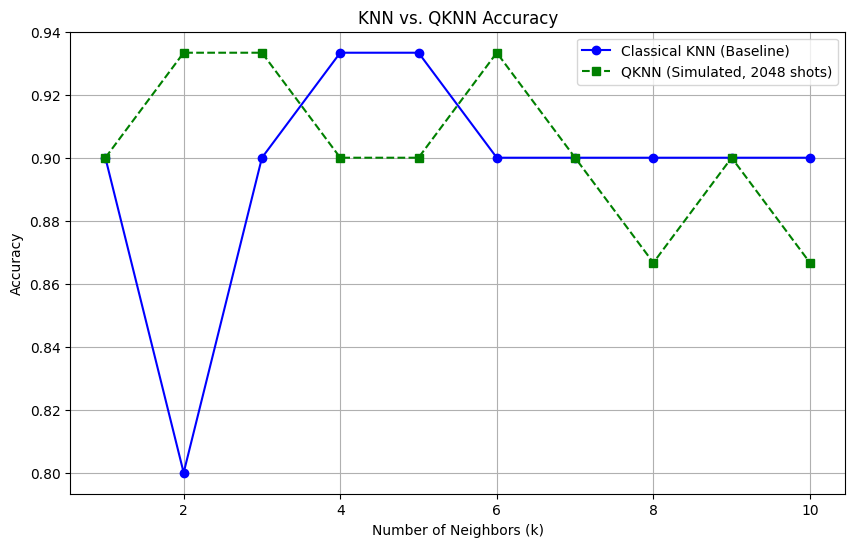

In [ ]:
# Generate Accuracy Plots
print("Generating Accuracy vs. k Plot")
k_values = range(1, 11)
classical_accuracies = []
qknn_accuracies = []

for k_val in k_values:
    print(f"Running for k={k_val}")
    # Classical
    knn = KNeighborsClassifier(n_neighbors=k_val, metric='euclidean')
    knn.fit(X_train_norm, y_train)
    classical_accuracies.append(accuracy_score(y_test, knn.predict(X_test_norm)))

    # Quantum
    qknn = QKNNClassifier(n_neighbors=k_val)
    qknn.fit(X_train_norm, y_train)
    # We only need to predict once for the test set
    qknn_preds = qknn.predict(X_test_norm)
    qknn_accuracies.append(accuracy_score(y_test, qknn_preds))


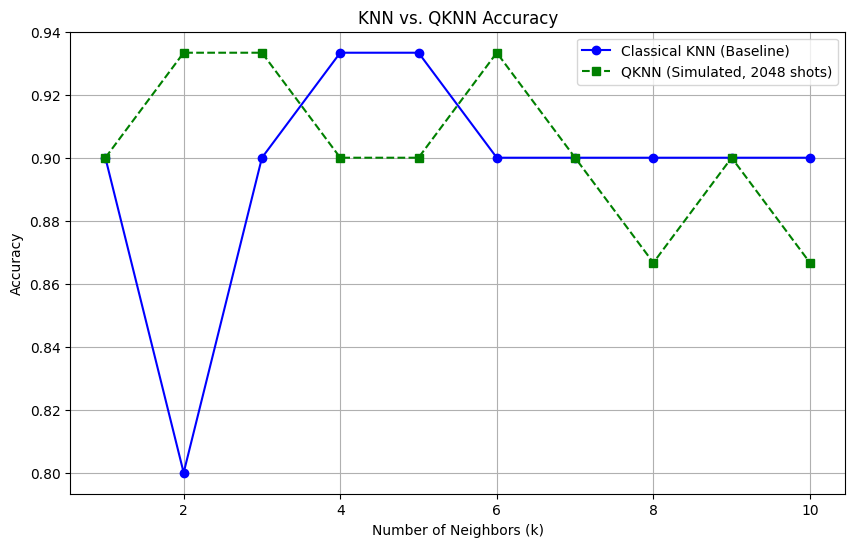

In [ ]:
# Plotting Accuracy vs.k
plt.figure(figsize=(10, 6))
plt.plot(k_values, classical_accuracies, 'bo-', label='Classical KNN (Baseline)')
plt.plot(k_values, qknn_accuracies, 'gs--', label=f'QKNN (Simulated, {SHOTS} shots)')
plt.title('KNN vs. QKNN Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()